# Packing UVs in to FDMT runs

We have few thousand UV points. Each UV point has a contiguous list of channels, given by a channel start-end inclusive. 

The channel numbers range from 0-255. A UV can have any number from 1 to 255 channels.

We have a procesor. The processor can process at most 8 UVs per run. For each UV it processes, it can only process 32 channels. When the processor executes a run, the channel range for each UV in that run must be identical.

So for example:

UV[0] has channels 0-31.
UV[1] has channels 10-20
UV[2] has channels 20-42


We can pack it as follows:
Run [0] has channels 0-31 and conatins
UV[0] channels 0-31
UV[1] channels 10-20
UV[2] channels 30-31

The remaining channels of UV[2] have to be deferred to a later run.

ie.
Run[1] channels 20-51
UV[2] channels 20-42 can be processed in this run.





In [1]:
import numpy as np
from pylab import *


In [2]:
# load UV data from file
uvs = np.loadtxt('frb_d0_lm0_nt16_nant24.fits.uvgrid.txt')

# start channel for each UV is the 4th column
start_chans = uvs[:, 4]

# end channel for each uv is the 5th column (end channel is included in the range)
end_chans = uvs[:, 5]

# Make a list of lists
uvchans = list(zip(start_chans, end_chans))

# Number of channels in each uv is the difference
num_chans = end_chans - start_chans + 1

In [3]:
print("The number of UVs is", len(start_chans))

The number of UVs is 4053


Text(0, 0.5, 'Number of UVs')

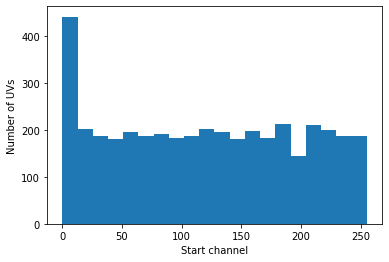

In [4]:
# plot histogram of start channels
hist(start_chans, bins=20)
xlabel('Start channel')
ylabel('Number of UVs')

Text(0, 0.5, 'Number of UVs')

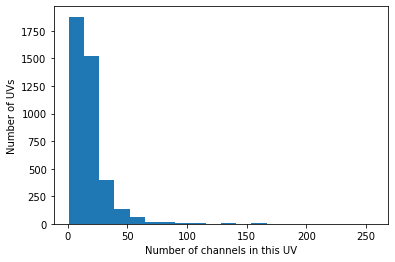

In [5]:
# plot histogram of number of channels in each UV
hist(num_chans, bins=20)
xlabel('Number of channels in this UV')
ylabel('Number of UVs')

In [22]:
# But actually the maximum number of channels is 32, so a small number of those UVs can't be processed in 1 run.
# Clearly some UVs contain more than 32 channels.
# Lets' see how many we'd have to break up
NCMAX = 32
NUVMAX = 8

num_uvs_gt_ncmax = sum(num_chans > NCMAX)
split_nuvs = sum(np.ceil(num_chans / NCMAX))
split_nruns = (split_nuvs + NUVMAX - 1)// NUVMAX
print(f'We started out with {len(uvchans)} UVs but {num_uvs_gt_ncmax} UVs have more than {NCMAX} channels')
print(f'If we split those up we end upwith {split_nuvs} UVs')
print(f'which, if you could pack them optimally, would take {split_nruns} runs to complete')
      



We started out with 4053 UVs but 403 UVs have more than 32 channels
If we split those up we end upwith 4556.0 UVs
which, if you could pack them optimally, would take 570.0 runs to complete


# Simple greedy algorithm

I haven't given you code for this because mine is probably to complicated to be illustrative, but here's the idea:
- Have a list of UVs you haven't done
- Find the lowest channel of the UVs you haven't done. The channel range for this run will be chan to chan+31 inclusive
- Calculate the overlap that each UV has with this run's channel range
- Find as many UVs (up to 8) with the largest amount of overlap and assign them to the this run
- Remove those UVs fromthe list of things to do
- Go back to the beginning


In [6]:
def calc_overlap_channels(chan_start, chan_end, minchan, ncin=32):
    '''
    Calculate overlap between 2 sets of channels
    
    If the 2 rangers overlap you get the number of overlaping channels.
    If they dont' overlap you get a negative number which is the distance between the two channel ranges

    :chan_start: first channel of baseline. Must be >= minchan
    :chan_end: last_cahnenl of baseline (inclusive)
    :minchan: First channel in range
    :nchan: Number of chanenls in range

    >>> calc_overlap_channels(0,31,0,32)
    32

    >>> calc_overlap_channels(0,30,0,32)
    31

    >>> calc_overlap_channels(0,33,0,32)
    32

    >>> calc_overlap_channels(0+1,31+1,0,32)
    31

    >>> calc_overlap_channels(31,64,0,32)
    1

    >>> calc_overlap_channels(32,64,0,32)
    0

    >>> calc_overlap_channels(33,64,0,32)
    -1

    '''
    assert chan_end >= chan_start
    assert chan_start >= minchan, 'invalid minimum chan {} {}'.format(chan_start, minchan)
    maxchan = minchan + ncin # top end of channels - inclusive

    if chan_end < maxchan:
        overlap = chan_end - chan_start + 1
    else:
        overlap = maxchan - chan_start

    #print(chan_start, chan_end, minchan, maxchan, ncin, overlap)

    return overlap

In [7]:

def greedy_algorithm(uvchans):
    runs = []
    
    minimum_nruns = (len(uvchans) + 8 - 1) // 8 # // in python means integer division
    print(f'Started with {len(uvchans)} uvs which would need at least {minimum_nruns} runs')

    uvchans_left = uvchans[:] # copy list
    
        
    while len(uvchans_left) > 0:
        print('We have ', len(uvchans_left), 'UVs left')

        # Find the UV with the smallest start_chan
        minuv = min(uvchans_left, key=lambda uv:uv[0])        
        
        # find that start channel
        run_start_chan = minuv[0]
        
        # end channel of this run is
        run_end_chan = run_start_chan + 31 # inclusive
        
        # make a list of all UVs with a positive overlap - these UVs could be in this run.
        possible_uvs = [uv for uv in uvchans_left if calc_overlap_channels(uv[0], uv[1], run_start_chan) > 0]
        
        # Sort UVs by how much overlap they have with this channel range
        # UVs with the largest overlap will be first in this list
        uv_sorted = sorted(possible_uvs, key=lambda uv:calc_overlap_channels(uv[0], uv[1], run_start_chan), reverse=True)               
        
        # Extract no more than 8 Uvs from the list of UVs with the most overlap
        this_run_uvs = uv_sorted[0:min(8, len(uv_sorted))]
        
        uvs_for_this_run = []
        
        # for each UV in this run
        for uv in this_run_uvs:
            
            # remove it from the list of things to do
            uvchans_left.remove(uv)            
                      
            # If this uv final channel is beynd the channel range in this run we have to split it in two pieces
            uv_start_chan = uv[0]
            uv_end_chan = uv[1]
            assert uv_end_chan >= uv_start_chan
            if uv_end_chan > run_end_chan:
                # Add the subset of channels we *can* use to this run
                uvs_for_this_run.append((uv_start_chan, run_end_chan))
                
                # Add the leftover channels to the list of things to do
                uvchans_left.append((run_end_chan+1, uv_end_chan))                
                
            else: # The whole channel range does fit in the run
                # Add the whole UV to this run
                uvs_for_this_run.append((uv_start_chan, uv_end_chan))
                
        runs.append(uvs_for_this_run)
                

    return runs
            
                                          
    

In [8]:
greedy_runs = greedy_algorithm(uvchans)


Started with 4053 uvs which would need at least 507 runs
We have  4053 UVs left
We have  4053 UVs left
We have  4053 UVs left
We have  4052 UVs left
We have  4050 UVs left
We have  4049 UVs left
We have  4043 UVs left
We have  4036 UVs left
We have  4030 UVs left
We have  4024 UVs left
We have  4019 UVs left
We have  4014 UVs left
We have  4007 UVs left
We have  4001 UVs left
We have  3995 UVs left
We have  3990 UVs left
We have  3983 UVs left
We have  3977 UVs left
We have  3972 UVs left
We have  3966 UVs left
We have  3962 UVs left
We have  3957 UVs left
We have  3952 UVs left
We have  3948 UVs left
We have  3943 UVs left
We have  3937 UVs left
We have  3930 UVs left
We have  3924 UVs left
We have  3917 UVs left
We have  3910 UVs left
We have  3904 UVs left
We have  3898 UVs left
We have  3892 UVs left
We have  3887 UVs left
We have  3880 UVs left
We have  3875 UVs left
We have  3869 UVs left
We have  3864 UVs left
We have  3859 UVs left
We have  3853 UVs left
We have  3846 UVs left


We have  2396 UVs left
We have  2395 UVs left
We have  2393 UVs left
We have  2392 UVs left
We have  2391 UVs left
We have  2391 UVs left
We have  2390 UVs left
We have  2390 UVs left
We have  2389 UVs left
We have  2388 UVs left
We have  2385 UVs left
We have  2385 UVs left
We have  2377 UVs left
We have  2373 UVs left
We have  2369 UVs left
We have  2362 UVs left
We have  2360 UVs left
We have  2353 UVs left
We have  2346 UVs left
We have  2344 UVs left
We have  2337 UVs left
We have  2330 UVs left
We have  2329 UVs left
We have  2321 UVs left
We have  2317 UVs left
We have  2316 UVs left
We have  2314 UVs left
We have  2306 UVs left
We have  2299 UVs left
We have  2298 UVs left
We have  2297 UVs left
We have  2293 UVs left
We have  2285 UVs left
We have  2280 UVs left
We have  2280 UVs left
We have  2275 UVs left
We have  2267 UVs left
We have  2263 UVs left
We have  2259 UVs left
We have  2251 UVs left
We have  2245 UVs left
We have  2243 UVs left
We have  2240 UVs left
We have  22

We have  870 UVs left
We have  864 UVs left
We have  863 UVs left
We have  858 UVs left
We have  850 UVs left
We have  850 UVs left
We have  848 UVs left
We have  841 UVs left
We have  837 UVs left
We have  835 UVs left
We have  829 UVs left
We have  823 UVs left
We have  820 UVs left
We have  813 UVs left
We have  805 UVs left
We have  803 UVs left
We have  801 UVs left
We have  796 UVs left
We have  788 UVs left
We have  783 UVs left
We have  780 UVs left
We have  774 UVs left
We have  766 UVs left
We have  761 UVs left
We have  757 UVs left
We have  754 UVs left
We have  746 UVs left
We have  745 UVs left
We have  745 UVs left
We have  743 UVs left
We have  743 UVs left
We have  743 UVs left
We have  743 UVs left
We have  741 UVs left
We have  740 UVs left
We have  740 UVs left
We have  740 UVs left
We have  740 UVs left
We have  740 UVs left
We have  734 UVs left
We have  730 UVs left
We have  728 UVs left
We have  720 UVs left
We have  717 UVs left
We have  713 UVs left
We have  7

In [9]:
def plot_runs(runs):
    print('We started out with', len(start_chans), 'UVs and weve packed them into', len(runs), 'runs')
    print('Each processes 8 UVs, so the effective number of UVs we process is', 8*len(runs))
    
    run_number_of_uvs = [len(run) for run in runs]
    figure()
    plot(run_number_of_uvs)
    xlabel('Run number')
    ylabel('Number of UVs in run')
    title('Number of Uvs in run vs run number')
    
    figure()
    run_start_chans = [min(run, key=lambda uv:uv[0])[0] for run in runs]
    plot(run_start_chans)
    xlabel('Run number')
    ylabel('Lowest channel in run')
    title('Run channel number vs run number')
    
    
    figure()
    total_chans = [sum([uv[1] - uv[0] + 1 for uv in run]) for run in runs]
    plot(total_chans)
    axhline(8*32) # maximum possible
    ylabel('Total number of channels procesed in run')
    xlabel('Run number')

This shows the greedy algorithm is successful:i.e. there are almost always 8 UVs in the run

The channel number assigned to this run is generally increasing. For some reason it jumps up - I guess it exausts everything in the range and needs to add things to the next run all the time.

We started out with 4053 UVs and weve packed them into 962 runs
Each processes 8 UVs, so the effective number of UVs we process is 7696


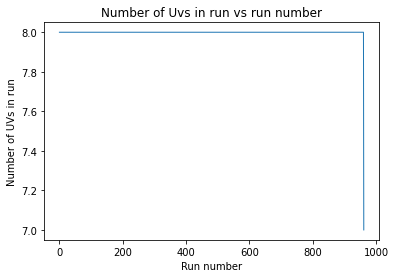

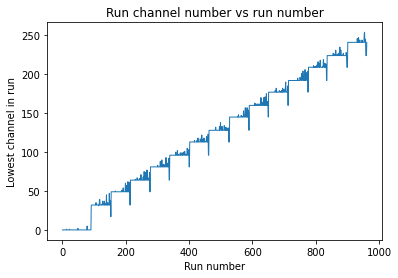

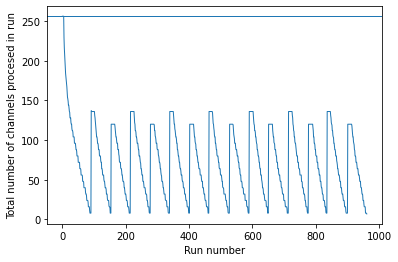

In [10]:
plot_runs(greedy_runs)

# What about using a fixed set of channel positions?

We could restrict the run channel position to a fixed set (e.g. 0, 16, 32, ...) or (0, 32,....) and see whether adding that structure somehow helps things.

In [11]:
def fixed_algorithm(uvchans, chan_positions):
    '''
    Start with a fixed set of given by the chan_positions array.
    When starting a run, find an appropriate channel from the chan_positions array 
    and use that
    '''
    runs = []
        
    uvchans_left = uvchans[:] # copy list
    minimum_nruns = (len(uvchans) + 8 - 1) // 8 # // in python means integer division
    print(f'Started with {len(uvchans)} uvs which would need at least {minimum_nruns} runs')

    
        
    while len(uvchans_left) > 0:
        #print('We have ', len(uvchans_left), 'UVs left')

        # Find start channel from list of chan_positions that has 
        minuv = min(uvchans_left, key=lambda uv:uv[0])        
        
        # find that start channel
        lowest_chan = minuv[0]
        
        # make list of channels from chan_positions that brackets lowest_chan
        possible_chans = list(filter(lambda c: c <= lowest_chan <= c+31,chan_positions))
        assert len(possible_chans) > 0, 'Channel positions cant handle channel {}'.format(lowest_chan)
        
        # channel to use is the largest of these - which gives the best chance of including lots of other channels
        
        run_start_chan = max(possible_chans)
        assert run_start_chan in chan_positions
        
        # end channel of this run is
        run_end_chan = run_start_chan + 31 # inclusive
        
        # make a list of all UVs with a positive overlap - these UVs could be in this run.
        possible_uvs = [uv for uv in uvchans_left if calc_overlap_channels(uv[0], uv[1], run_start_chan) > 0]
        
        # Sort UVs by how much overlap they have with this channel range
        # UVs with the largest overlap will be first in this list
        uv_sorted = sorted(possible_uvs, key=lambda uv:calc_overlap_channels(uv[0], uv[1], run_start_chan), reverse=True)               
        
        # Extract no more than 8 Uvs from the list of UVs with the most overlap
        this_run_uvs = uv_sorted[0:min(8, len(uv_sorted))]
        
        uvs_for_this_run = []
        
        # for each UV in this run
        for uv in this_run_uvs:
            
            # remove it from the list of things to do
            uvchans_left.remove(uv)            
                      
            # If this uv final channel is beynd the channel range in this run we have to split it in two pieces
            uv_start_chan = uv[0]
            uv_end_chan = uv[1]
            assert uv_end_chan >= uv_start_chan
            if uv_end_chan > run_end_chan:
                # Add the subset of channels we *can* use to this run
                uvs_for_this_run.append((uv_start_chan, run_end_chan))
                
                # Add the leftover channels to the list of things to do
                uvchans_left.append((run_end_chan+1, uv_end_chan))                
                
            else: # The whole channel range does fit in the run
                # Add the whole UV to this run
                uvs_for_this_run.append((uv_start_chan, uv_end_chan))
                
        runs.append(uvs_for_this_run)
                

    increase = len(runs)/minimum_nruns
    print(f'With {len(chan_positions)} channels at {chan_positions} we needed {len(runs)} runs. An increase of {increase} ')
            
    return runs
            

In [12]:
f8 = fixed_algorithm(uvchans, np.arange(0,256,8))
f16 = fixed_algorithm(uvchans, np.arange(0,256,16))
f32 = fixed_algorithm(uvchans, np.arange(0,256,32))




Started with 4053 uvs which would need at least 507 runs
With 32 channels at [  0   8  16  24  32  40  48  56  64  72  80  88  96 104 112 120 128 136
 144 152 160 168 176 184 192 200 208 216 224 232 240 248] we needed 965 runs. An increase of 1.903353057199211 
Started with 4053 uvs which would need at least 507 runs
With 16 channels at [  0  16  32  48  64  80  96 112 128 144 160 176 192 208 224 240] we needed 965 runs. An increase of 1.903353057199211 
Started with 4053 uvs which would need at least 507 runs
With 8 channels at [  0  32  64  96 128 160 192 224] we needed 738 runs. An increase of 1.455621301775148 


We started out with 4053 UVs and weve packed them into 965 runs
Each processes 8 UVs, so the effective number of UVs we process is 7720


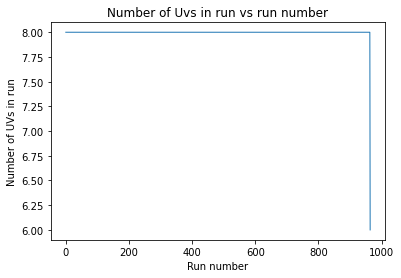

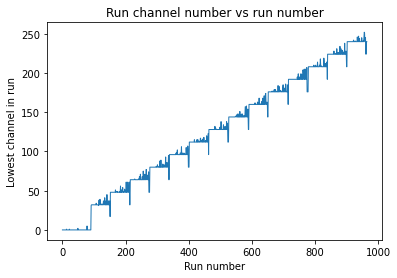

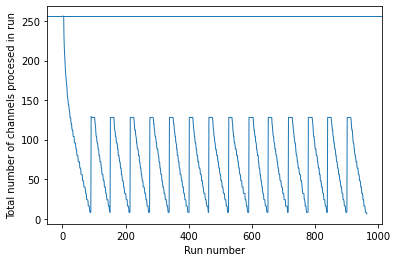

In [16]:
plot_runs(f8)
# OK - so the run channels doens't change much for fixed with span of 8 because when I plot these I plot the 
# Bottom channel of the UVs in the run. Not the channel we decided would be the bottom channel - which is slightly different

We started out with 4053 UVs and weve packed them into 738 runs
Each processes 8 UVs, so the effective number of UVs we process is 5904


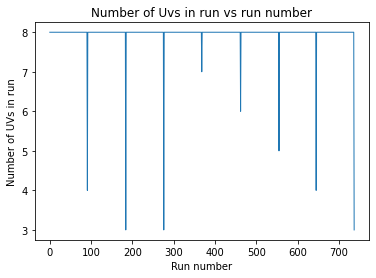

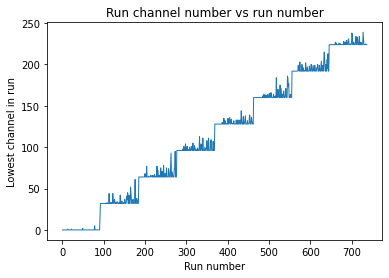

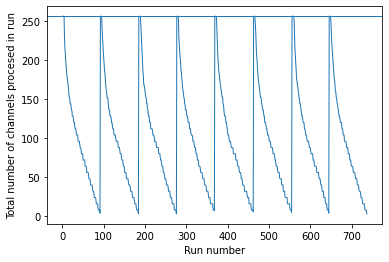

In [17]:
plot_runs(f32)

In [15]:
print(f'A fully dynamic run required {len(greedy_runs)} runs')

A fully dynamic run required 962 runs


# WOW! 

So it looks like the fixed algorithm with steps of 32 channels does a much better job than anything so far. I.e. An increase of only 1.45, rather than ~1.9 for everything else.